In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, LeaveOneOut, StratifiedKFold, cross_val_score, learning_curve, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [2]:
energy = pd.read_csv("./energy.csv")
energy = energy.iloc[:,:-2]
energy.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


In [3]:
energy.shape

(770, 10)

In [4]:
energy.rename(columns={"X1":"relative_compactness", "X2":"surface_area","X3":"wall_area", "X4":"roof_area",
                      "X5":"height", "X6":"orientation", "X7":"glazing_area", "X8":"glazing_area_distribution",
                      "Y1":"heating_load", "Y2":"cooling_load"}, inplace=True)
energy.head()

,relative_compactness,surface_area,wall_area,roof_area,height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


In [5]:
energy.isna().sum()

relative_compactness         2
surface_area                 2
wall_area                    2
roof_area                    2
height                       2
orientation                  2
glazing_area                 2
glazing_area_distribution    2
heating_load                 2
cooling_load                 2
dtype: int64

In [6]:
energy.dropna(axis=0, inplace=True)
energy.isna().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
height                       0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
cooling_load                 0
dtype: int64

In [7]:
energy["total_load"] = energy["heating_load"] + energy["cooling_load"]
energy['heating_cooling_ratio'] = energy['heating_load'] / (energy['cooling_load'] + 1e-6)  # Avoid division by zero
energy['cooling_heating_ratio'] = energy['cooling_load'] / (energy['heating_load'] + 1e-6)

In [8]:
energy.head()

,relative_compactness,surface_area,wall_area,roof_area,height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load,total_load,heating_cooling_ratio,cooling_heating_ratio
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33,36.88,0.729020,1.371704
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33,36.88,0.729020,1.371704
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33,36.88,0.729020,1.371704
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33,36.88,0.729020,1.371704
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28,49.12,0.736917,1.357006


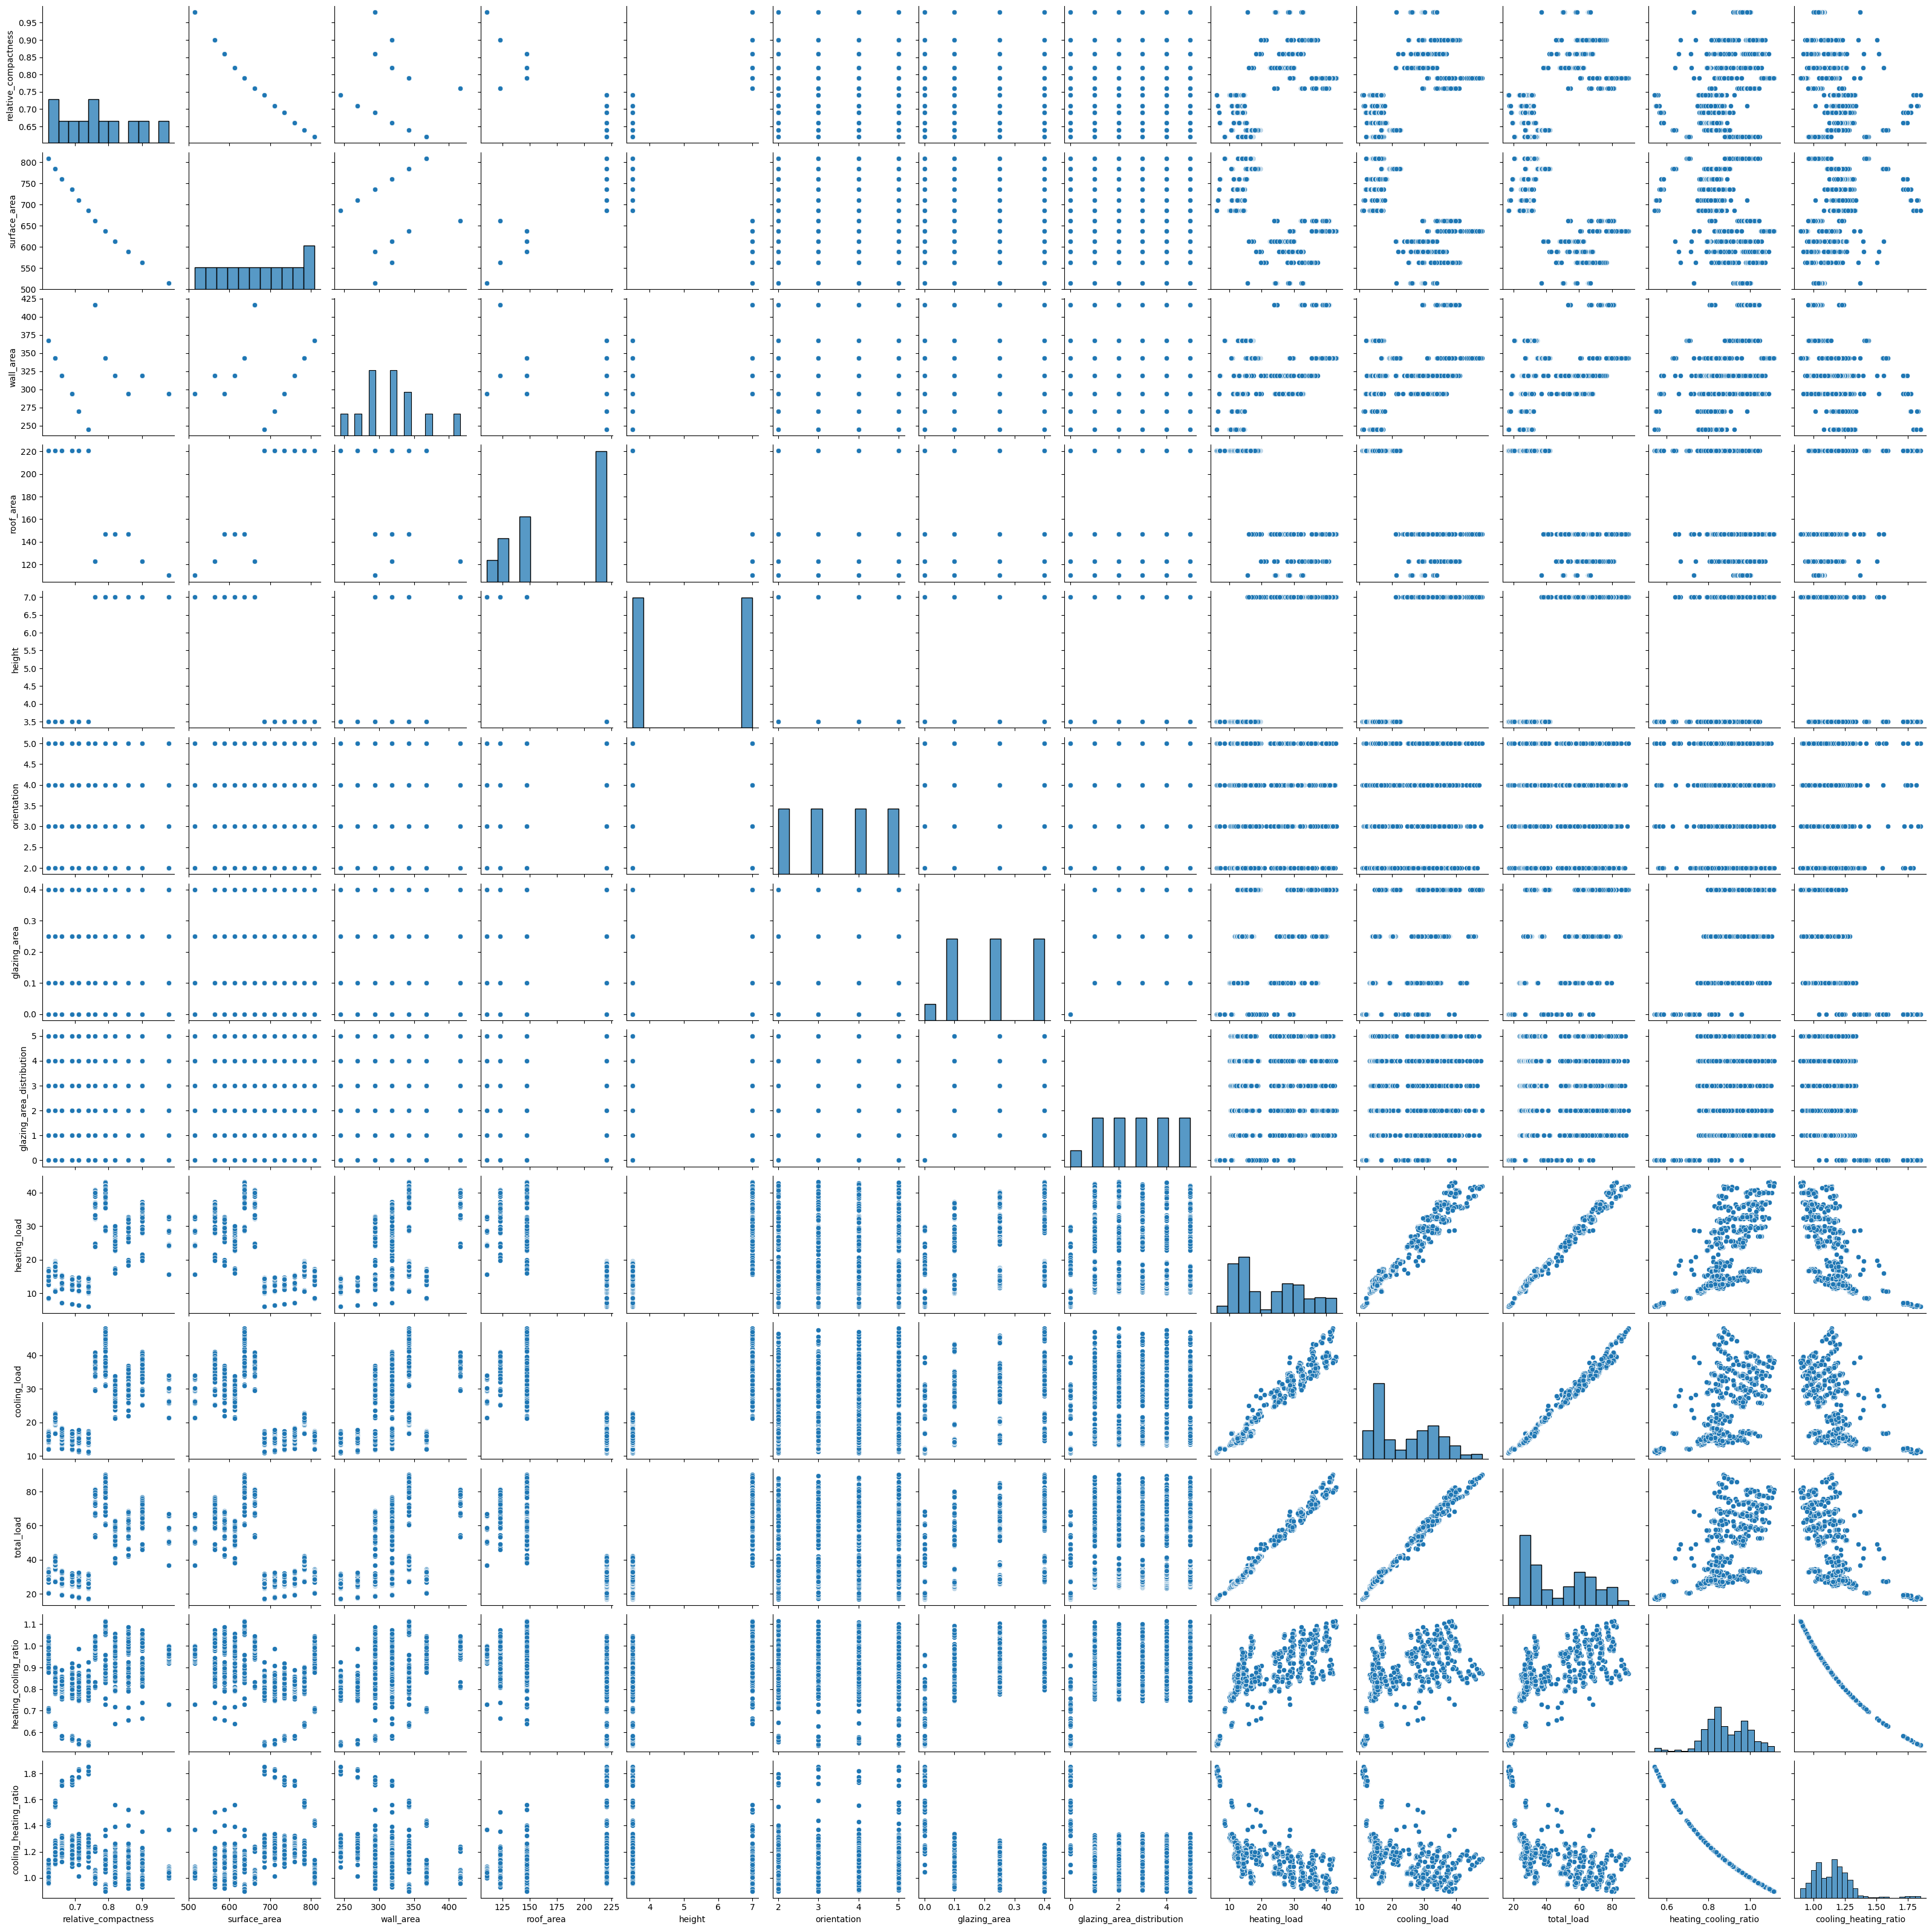

In [9]:
sns.pairplot(energy)
plt.show()

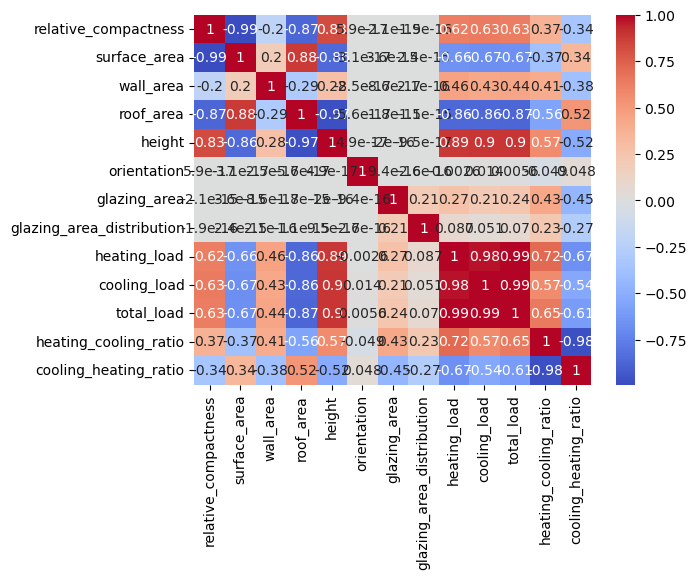

In [10]:
sns.heatmap(energy.corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 767
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   height                     768 non-null    float64
 5   orientation                768 non-null    float64
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    float64
 8   heating_load               768 non-null    float64
 9   cooling_load               768 non-null    float64
 10  total_load                 768 non-null    float64
 11  heating_cooling_ratio      768 non-null    float64
 12  cooling_heating_ratio      768 non-null    float64
dtypes: float64(13)
memory usage: 84.0 KB


In [12]:
X = energy.drop(columns=['heating_load',	'cooling_load',	'total_load',	'heating_cooling_ratio',	'cooling_heating_ratio'], axis=1)
X

,relative_compactness,surface_area,wall_area,roof_area,height,orientation,glazing_area,glazing_area_distribution
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5.0,0.4,5.0
764,0.62,808.5,367.5,220.50,3.5,2.0,0.4,5.0
765,0.62,808.5,367.5,220.50,3.5,3.0,0.4,5.0
766,0.62,808.5,367.5,220.50,3.5,4.0,0.4,5.0


In [13]:
y = energy[['heating_load',	'cooling_load',	'total_load',	'heating_cooling_ratio',	'cooling_heating_ratio']]
y

,heating_load,cooling_load,total_load,heating_cooling_ratio,cooling_heating_ratio
0,15.55,21.33,36.88,0.729020,1.371704
1,15.55,21.33,36.88,0.729020,1.371704
2,15.55,21.33,36.88,0.729020,1.371704
3,15.55,21.33,36.88,0.729020,1.371704
4,20.84,28.28,49.12,0.736917,1.357006
...,...,...,...,...,...
763,17.88,21.40,39.28,0.835514,1.196868
764,16.54,16.88,33.42,0.979858,1.020556
765,16.44,17.11,33.55,0.960842,1.040754
766,16.48,16.61,33.09,0.992173,1.007888


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
def build_nn_model(input_dim):
    model = Sequential()

    # Input Layer
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Hidden Layer 2
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 3
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Hidden Layer 4
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Hidden Layer 4
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(5, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model


Elastic_net scores:
   r2: 0.5143
   mean_squared_error: 14.5754
   root_mean_squared_error: 3.8087
   median_absolute_error: 1.4609
   mean_absolute_error: 1.9953


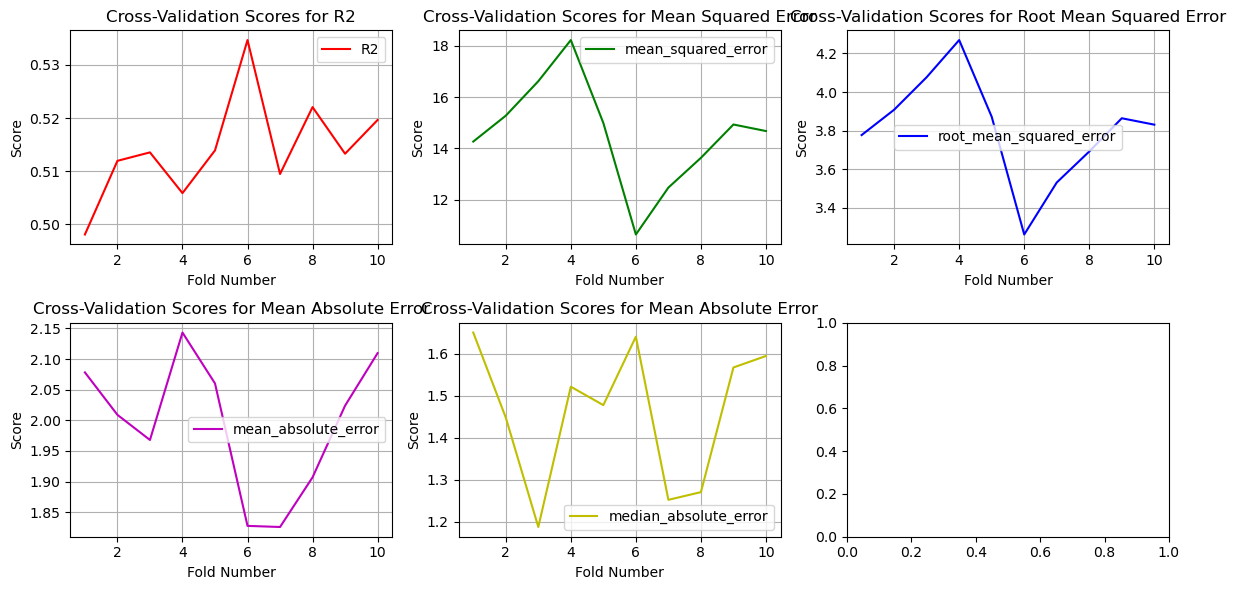

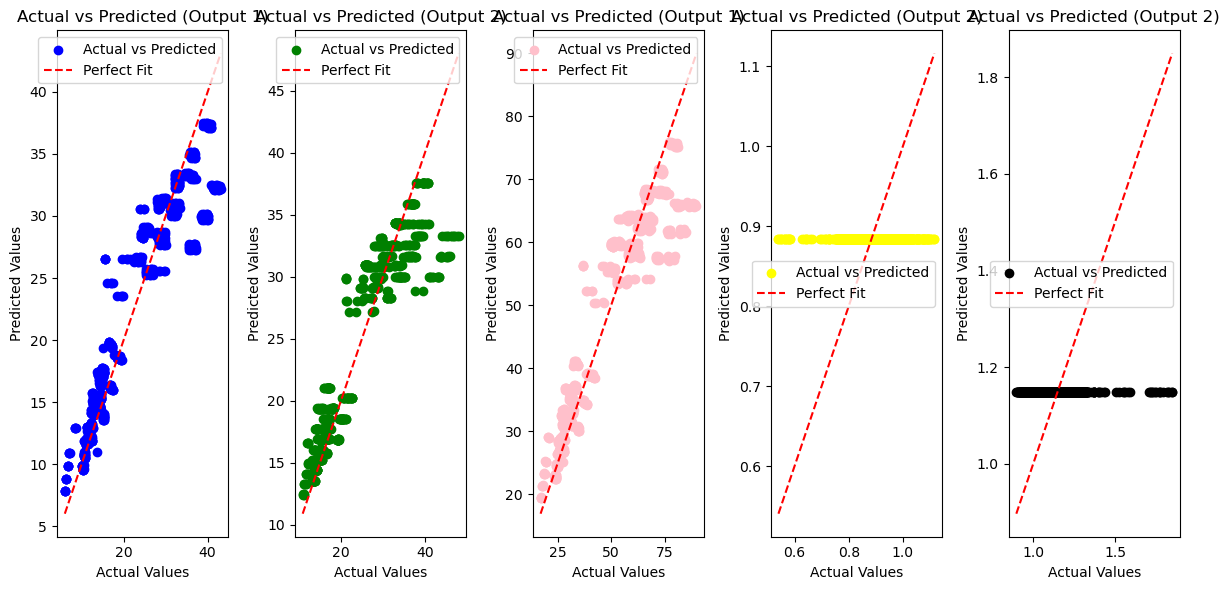

Overall R2 score on full dataset:  0.5220418300406738

Random_forest scores:
   r2: 0.8693
   mean_squared_error: 1.2942
   root_mean_squared_error: 1.1316
   median_absolute_error: 0.2047
   mean_absolute_error: 0.5001


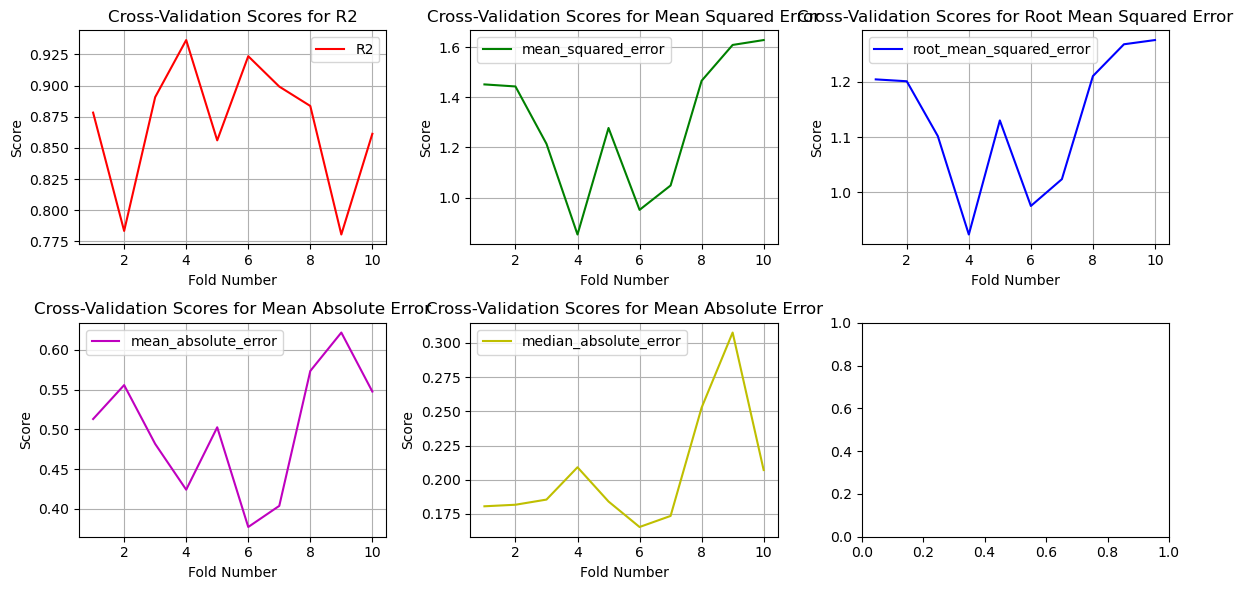

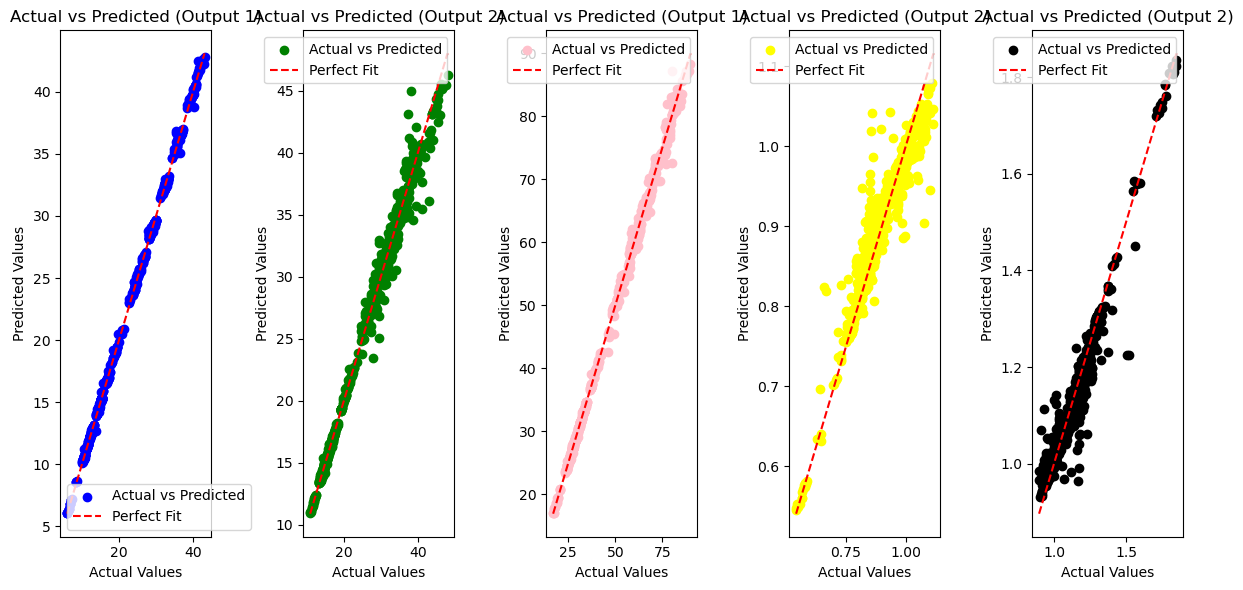

Overall R2 score on full dataset:  0.969543754566342

Neural network scores:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x17dd09800> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━

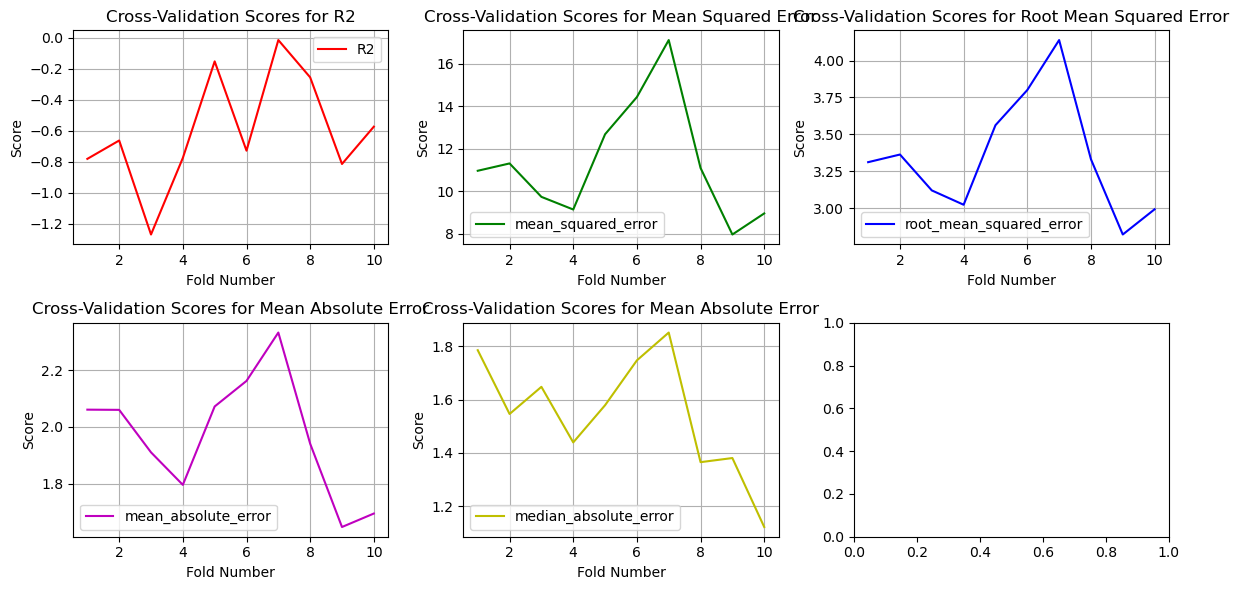

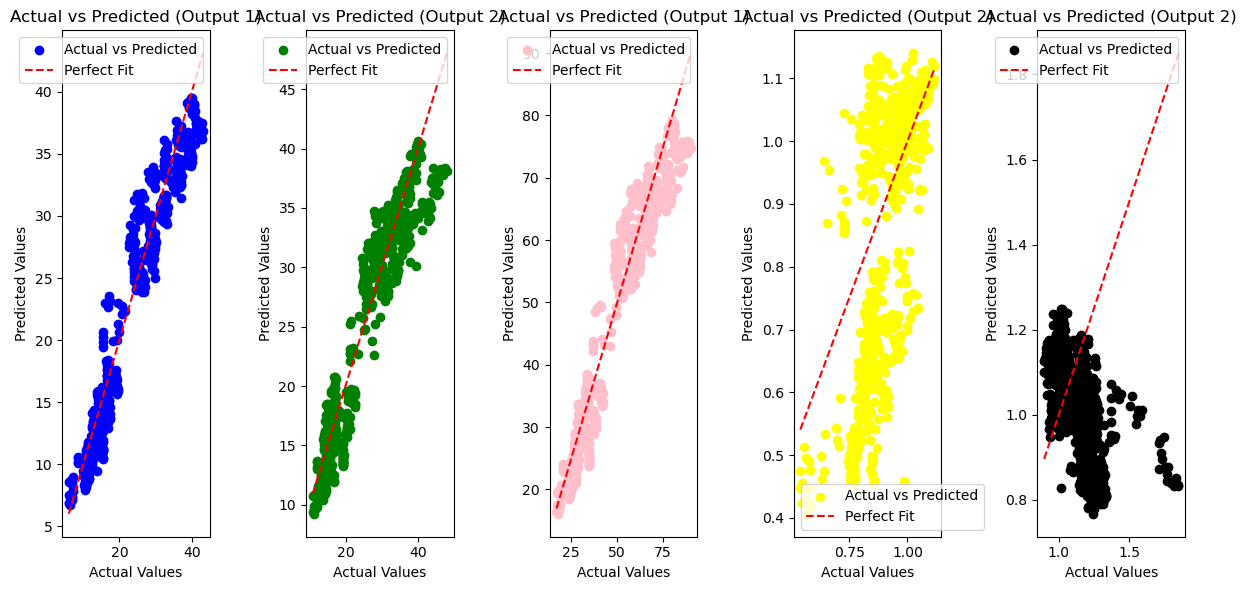

Overall R2 score on full dataset:  -0.30179318491604434


In [16]:
scores = ['r2', 'mean_squared_error', 'root_mean_squared_error', 'median_absolute_error', 'mean_absolute_error']
cv = KFold(n_splits=10, shuffle=True)

# Define regressors
regressors = {
    "Elastic_net": ElasticNet(alpha=0.4),
    "Random_forest": RandomForestRegressor(),
    "Neural network": "Keras"
}

# Iterate through each regressor
for regressor_name, model in regressors.items():
    print(f'\n{regressor_name} scores:')
    
    # Initialize storage for metric results
    metric_results = {score: [] for score in scores}
    fold_models = []  # Reset fold models for each regressor

    # Perform manual KFold cross-validation
    for train_idx, test_idx in cv.split(X):
        # Split the data
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Handle Keras model separately to create a fresh instance each time
        if model == "Keras":
            keras_model = build_nn_model(input_dim=X_train.shape[1])
            keras_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
            y_pred = keras_model.predict(X_test)  # Flatten to 1D array
            fold_models.append(keras_model)
        else:
            # For scikit-learn models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_models.append(model)

        # Calculate and store each metric manually
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)

        # Store the scores (negate where necessary to match cross_val_score convention)
        metric_results['r2'].append(r2)
        metric_results['mean_squared_error'].append(mse)
        metric_results['root_mean_squared_error'].append(rmse)
        metric_results['mean_absolute_error'].append(mae)
        metric_results['median_absolute_error'].append(medae)

    # Display average scores
    for score in scores:
        mean_score = np.mean(metric_results[score])
        print(f'   {score}: {mean_score:.4f}')

    # Select a random model from this regressor's folds
    random_model = random.choice(fold_models)
    if regressor_name == "Neural Network (Keras)":
        y_hat = random_model.predict(X_scaled)
    else:
        y_hat = random_model.predict(X_scaled)
    
    # Plot cross-validation scores
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))

    # Plotting only R2 in the second subplot
    ax[0,0].plot(
        range(1, len(metric_results['r2']) + 1),
        metric_results['r2'],
        label='R2',
        color='r'
    )
    ax[0,0].set_title("Cross-Validation Scores for R2")
    ax[0,0].set_xlabel("Fold Number")
    ax[0,0].set_ylabel("Score")
    ax[0,0].legend(loc="best")
    ax[0,0].grid(True)
    
    ax[0,1].plot(
        range(1, len(metric_results['mean_squared_error']) + 1),
        metric_results['mean_squared_error'],
        label='mean_squared_error',
        color='g'
    )
    ax[0,1].set_title("Cross-Validation Scores for Mean Squared Error")
    ax[0,1].set_xlabel("Fold Number")
    ax[0,1].set_ylabel("Score")
    ax[0,1].legend(loc="best")
    ax[0,1].grid(True)

    ax[0,2].plot(
        range(1, len(metric_results['mean_squared_error']) + 1),
        metric_results['root_mean_squared_error'],
        label='root_mean_squared_error',
        color='b'
    )
    ax[0,2].set_title("Cross-Validation Scores for Root Mean Squared Error")
    ax[0,2].set_xlabel("Fold Number")
    ax[0,2].set_ylabel("Score")
    ax[0,2].legend(loc="best")
    ax[0,2].grid(True)

    ax[1,0].plot(
        range(1, len(metric_results['mean_absolute_error']) + 1),
        metric_results['mean_absolute_error'],
        label='mean_absolute_error',
        color='m'
    )
    ax[1,0].set_title("Cross-Validation Scores for Mean Absolute Error")
    ax[1,0].set_xlabel("Fold Number")
    ax[1,0].set_ylabel("Score")
    ax[1,0].legend(loc="best")
    ax[1,0].grid(True)

    ax[1,1].plot(
        range(1, len(metric_results['median_absolute_error']) + 1),
        metric_results['median_absolute_error'],
        label='median_absolute_error',
        color='y'
    )
    ax[1,1].set_title("Cross-Validation Scores for Mean Absolute Error")
    ax[1,1].set_xlabel("Fold Number")
    ax[1,1].set_ylabel("Score")
    ax[1,1].legend(loc="best")
    ax[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 5, figsize=(12, 6))

    # Scatter plot for the first output
    axes[0].scatter(y.iloc[:, 0], y_hat[:, 0], color='blue', label='Actual vs Predicted')
    axes[0].plot([y.iloc[:, 0].min(), y.iloc[:, 0].max()], [y.iloc[:, 0].min(), y.iloc[:, 0].max()], 'r--', label='Perfect Fit')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Actual vs Predicted (Output 1)')
    axes[0].legend()
    
    # Scatter plot for the second output
    axes[1].scatter(y.iloc[:, 1], y_hat[:, 1], color='green', label='Actual vs Predicted')
    axes[1].plot([y.iloc[:, 1].min(), y.iloc[:, 1].max()], [y.iloc[:, 1].min(), y.iloc[:, 1].max()], 'r--', label='Perfect Fit')
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].set_title('Actual vs Predicted (Output 2)')
    axes[1].legend()

    # Scatter plot for the third output
    axes[2].scatter(y.iloc[:, 2], y_hat[:, 2], color='pink', label='Actual vs Predicted')
    axes[2].plot([y.iloc[:, 2].min(), y.iloc[:, 2].max()], [y.iloc[:, 2].min(), y.iloc[:, 2].max()], 'r--', label='Perfect Fit')
    axes[2].set_xlabel('Actual Values')
    axes[2].set_ylabel('Predicted Values')
    axes[2].set_title('Actual vs Predicted (Output 1)')
    axes[2].legend()
    
    # Scatter plot for the fourth output
    axes[3].scatter(y.iloc[:, 3], y_hat[:, 3], color='yellow', label='Actual vs Predicted')
    axes[3].plot([y.iloc[:, 3].min(), y.iloc[:, 3].max()], [y.iloc[:, 3].min(), y.iloc[:, 3].max()], 'r--', label='Perfect Fit')
    axes[3].set_xlabel('Actual Values')
    axes[3].set_ylabel('Predicted Values')
    axes[3].set_title('Actual vs Predicted (Output 2)')
    axes[3].legend()

      # Scatter plot for the fifth output
    axes[4].scatter(y.iloc[:, 4], y_hat[:, 4], color='black', label='Actual vs Predicted')
    axes[4].plot([y.iloc[:, 4].min(), y.iloc[:, 4].max()], [y.iloc[:, 4].min(), y.iloc[:, 4].max()], 'r--', label='Perfect Fit')
    axes[4].set_xlabel('Actual Values')
    axes[4].set_ylabel('Predicted Values')
    axes[4].set_title('Actual vs Predicted (Output 2)')
    axes[4].legend()
    
    plt.tight_layout()
    plt.show()


    
    # Adding labels and grid
    print("Overall R2 score on full dataset: ", r2_score(y, y_hat))